# Audio Processing

Step 1: Data is to be loaded from downloads folder 'speech commands'

Step 2: Import all necessary libraries required for audio analysis like Librosa, tqdm

Step 3: Explore the data read which will return a list of tuples [(filepath, label), ...] using the function list_wavs

Step 4: Create function mel_feat which captures time and frequencies of data in compact way and returns log-mel spectrogram

Step 5: Limiting the number of files so ram is not overloaded

Step 6: Feature Extraction and compute mel_feat and collect X, y

Step 7: Label Encoding and training Random Forest model

Step 8: Check whether the classes are balanced using bar graph

Step 9: Plotting Waveform and Spectogram for one sample of each type

In [1]:
# data loaded from downloads folder speech commands
DATA_DIR = r"C:\Users\prady\Downloads\speech_commands" 
print("Using:", DATA_DIR)

Using: C:\Users\prady\Downloads\speech_commands


In [2]:
# Imported Libraries 
import os
import librosa
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import Audio, display
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from collections import Counter

In [3]:
# Explore DATA_DIR returns a list of tuples [(filepath, label), ...]
def list_wavs(base):
    items = []
    for label in sorted(os.listdir(base)):
        lab_path = os.path.join(base, label)
        if not os.path.isdir(lab_path):
            continue
        for fname in os.listdir(lab_path):
            if fname.lower().endswith(".wav"):
                items.append((os.path.join(lab_path, fname), label))
    return items

In [4]:
# This step is to capture time and frequencies of data in compact way
def mel_feat(wav, sr=16000, n_mels=40): #sr: sampling rate, n_mels: frequency resolution (the more we increase the more complicated it gets)
    S = librosa.feature.melspectrogram(y=wav, sr=sr, n_mels=n_mels)
    # power_to_db converts power to dB 
    S_db = librosa.power_to_db(S, ref=np.max)
    # flatten to vector
    return S_db.flatten()

In [5]:
# Number of files present
files = list_wavs(DATA_DIR)
print("Found total files:", len(files))

Found total files: 16471


In [6]:
# List of files and limiting them so ram is not overloaded
MAX_PER_CLASS = 1000   # Truncate each label to at most that many files (We can set none to get all files)
if MAX_PER_CLASS:
    limited = {}
    new_list = []
    for path, label in files:
        cnt = limited.get(label, 0)
        if cnt < MAX_PER_CLASS:
            new_list.append((path, label))
            limited[label] = cnt + 1
    files = new_list
    print("Using files after limit:", len(files)) # This gives the final number of files we will be using

Using files after limit: 7000


In [7]:
# Feature Extraction
sr = 16000
X = []
y = []
for path, label in tqdm(files, desc="Extracting (log-mel)"):
    wav, _ = librosa.load(path, sr=sr) # loads audio and resamples to 16 kHz if needed
    if len(wav) < sr:
        wav = np.pad(wav, (0, sr - len(wav))) # pad or trim to exactly 1 second
    else:
        wav = wav[:sr]
    X.append(mel_feat(wav, sr=sr, n_mels=40)) # X is (num_samples, feature dimensions) and y is (num_samples,)
    y.append(label)

Extracting (log-mel):   0%|          | 0/7000 [00:00<?, ?it/s]

In [8]:
# Checkikng the shape of extracted data
X = np.array(X)
y = np.array(y)
print("Features shape:", X.shape, "Labels shape:", y.shape)

Features shape: (7000, 1280) Labels shape: (7000,)


In [9]:
# Label Encoding and training Random Forest model
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

le = LabelEncoder()
y_enc = le.fit_transform(y)

Xtr, Xte, ytr, yte = train_test_split(X, y_enc, test_size=0.2, random_state=42, stratify=y_enc)

# Standardize features
scaler = StandardScaler()
Xtr = scaler.fit_transform(Xtr)
Xte = scaler.transform(Xte)

clf = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)
clf.fit(Xtr, ytr)
pred = clf.predict(Xte)
# Creating the confusion matrix
print(classification_report(yte, pred, target_names=le.classes_))
print("Confusion matrix:\n", confusion_matrix(yte, pred))

              precision    recall  f1-score   support

        down       0.82      0.89      0.85       200
        left       0.84      0.78      0.81       200
         off       0.85      0.78      0.81       200
          on       0.84      0.81      0.82       200
       right       0.89      0.83      0.86       200
        stop       0.92      0.88      0.90       200
          up       0.70      0.85      0.77       200

    accuracy                           0.83      1400
   macro avg       0.84      0.83      0.83      1400
weighted avg       0.84      0.83      0.83      1400

Confusion matrix:
 [[177   4   0   9   0   4   6]
 [  8 156   7   4  13   2  10]
 [  3   5 156   9   1   3  23]
 [ 14   3  11 162   2   1   7]
 [  7  11   2   4 166   0  10]
 [  4   1   2   1   0 176  16]
 [  4   6   5   5   4   6 170]]


In [10]:
plt.rcParams.update({"figure.figsize": (8,5)})

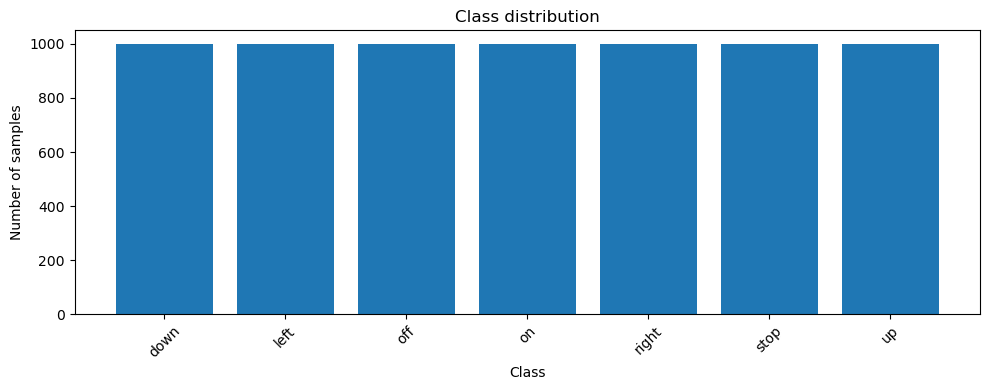

In [11]:
# See if the classes are balanced using bar graph
counts = Counter(y)
labels = sorted(counts.keys())
vals = [counts[l] for l in labels]

plt.figure(figsize=(10,4))
plt.bar(labels, vals)
plt.xticks(rotation=45)
plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.title("Class distribution")
plt.tight_layout()
plt.show()

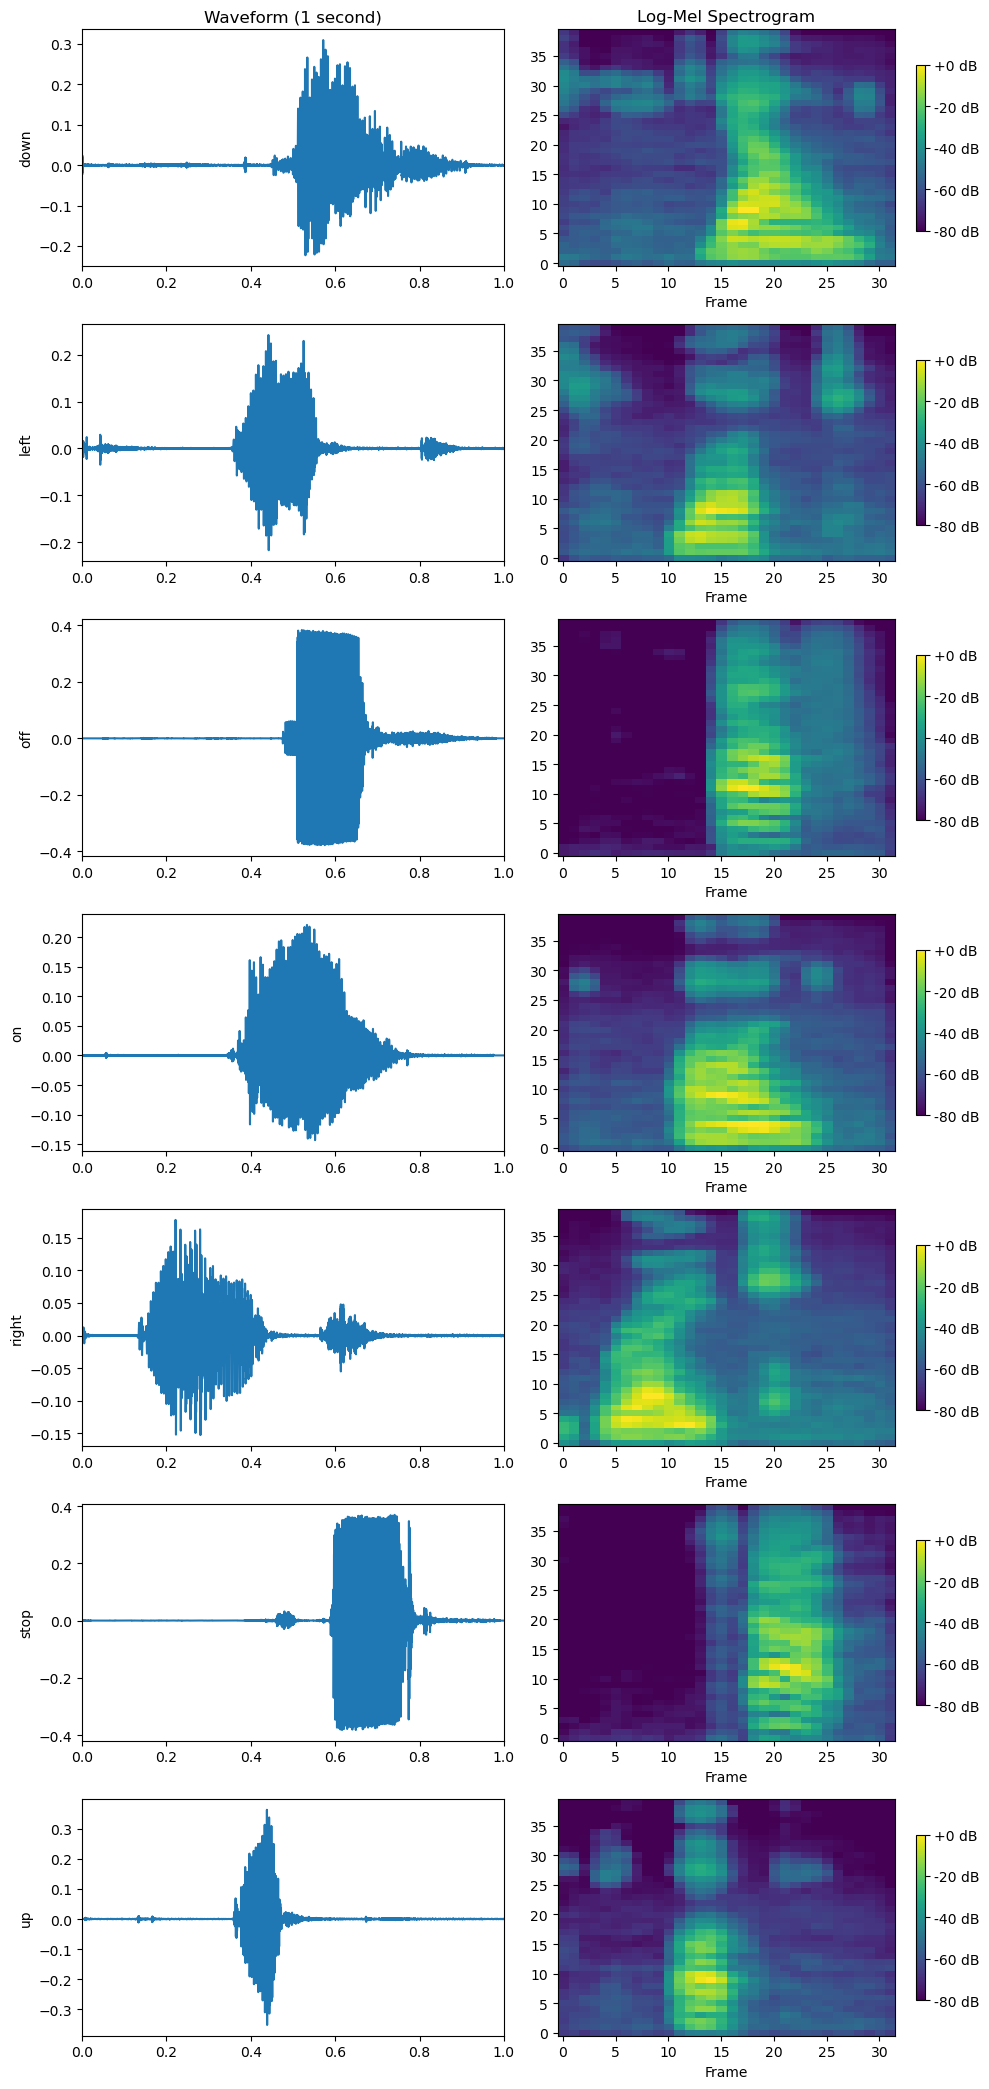

In [12]:
sr = 16000
examples = {}

# pick one example per class
for path, label in files:
    if label not in examples:
        examples[label] = path
    if len(examples) == len(set(y)):
        break

# plot up to 7 examples in a grid
n = min(7, len(examples))
selected = list(examples.items())[:n]

fig, axes = plt.subplots(n, 2, figsize=(10, 3*n))

for i, (label, path) in enumerate(selected):
    wav, _ = librosa.load(path, sr=sr)

    # pad or trim to 1 second
    if len(wav) < sr:
        wav = np.pad(wav, (0, sr - len(wav)))
    else:
        wav = wav[:sr]

    #  Waveform 
    axw = axes[i, 0]
    t = np.arange(len(wav)) / sr
    axw.plot(t, wav)
    axw.set_xlim(0, 1.0)
    axw.set_ylabel(label)
    if i == 0:
        axw.set_title("Waveform (1 second)")

    # Mel-Spectrogram 
    axm = axes[i, 1]
    S = librosa.feature.melspectrogram(y=wav, sr=sr, n_mels=40)
    S_db = librosa.power_to_db(S, ref=np.max)

    img = axm.imshow(S_db, aspect='auto', origin='lower')
    if i == 0:
        axm.set_title("Log-Mel Spectrogram")
    axm.set_xlabel("Frame")
    fig.colorbar(img, ax=axm, format="%+2.0f dB", shrink=0.7)

plt.tight_layout()
plt.show()